In [2]:
import random
import torch
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from torch.utils.tensorboard import SummaryWriter

c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [4]:
SEED = 1038893

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "../../data/ml-25m"

Device: cuda


## Data Acquisition

In [5]:
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

def get_movies_from_csv(nrows=None):
    path = "movies.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)
    print(data.head())
    return data

def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)

In [6]:
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"

In [7]:
ratings = get_ratings_from_csv()
movies = get_movies_from_csv()
print(ratings)

Loaded ml-25m data: ../../data/ml-25m/ratings.csv
Loaded ml-25m data: ../../data/ml-25m/movies.csv
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
          userId  movieId  rating
0              1      296     5.0
1              1      306     3.5
2              1      307     5.0
3              1      665     5.0
4              1      899     3.5
...          ...      ...     ...
25000090  162541    50872     4.5
25000091  162541    55768     2.5


In [8]:
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)

Loaded ml-25m data: ../../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 columns]


# DATA VISUALIZATION


In [9]:
def plot_model_hyperparams(grid,model_name):
    writer = SummaryWriter('run_pca/{}'.format(model_name))
    for i in range(len(grid.cv_results_['params'])):
        writer.add_hparams(
            {f'{k}': v for k, v in grid.cv_results_['params'][i].items()},
            {f'{model_name}_mean_test_score': grid.cv_results_['mean_test_score'][i]}
        )
    writer.flush()
    writer.close()


In [10]:
class RF:
    def __init__(self, ratings, relevance, seed=SEED):
        import matplotlib.pyplot as plt
        relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance')
    
        # Merge the ratings and relevance data
        mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
        X = mean_ratings.merge(relevance_matrix, on='movieId')
        
        X.columns = X.columns.astype(str)
        ratings = None  

        # mescolare le righe del DataFrame
        X = X.sample(frac=1,random_state=seed).reset_index(drop=True)
        
        X.drop("movieId", axis=1, inplace=True)
        y = X['rating']
        X = X.drop('rating', axis=1)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        #print(self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape)

        pca = PCA(n_components=0.95)
        pca.fit(self.X_train)
        self.X_train_t = pca.transform(self.X_train)
        self.X_test_t = pca.transform(self.X_test)
        print(self.X_test.shape, self.X_test_t.shape)
        plt.scatter(self.X_train_t[:, 0], self.X_train_t[:, 1], c=self.y_train, cmap='viridis')
        plt.show()
        
        plt.scatter(self.X_test_t[:, 0], self.X_test_t[:, 1], c=self.y_test, cmap='viridis')
        plt.show()


        self.model = RandomForestRegressor(random_state=seed)
        self.params = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None ,10, 50],
                'min_samples_split': [2, 5, 7],
                'min_samples_leaf': [1, 2, 5],
                'max_features': ['auto', 'sqrt', 'log2'],
                'random_state': [seed]
            }
            
    def train(self):
        self.model.fit(self.X_train, self.y_train)
    
     # Hyperparameter tuning
    def tuning(self):
        from sklearn.model_selection import RandomizedSearchCV
        search = RandomizedSearchCV(estimator = self.model, param_distributions = self.params, cv = 3, n_jobs = 20 )
        search.fit(self.X_train, self.y_train)
        plot_model_hyperparams(search,"RF")
        print(search.best_params_)
        self.model = search.best_estimator_
        print(f"Best score: {search.best_score_:.4f}")
        
    

    def test(self):
        # Predict ratings for the test data
        y_pred = self.model.predict(self.X_test)

        # Compute the mean squared error
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2 = r2_score(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)

        print(f"MSE: {mse} RMSE: {rmse} R2: {r2} MAE: {mae}")
        score = self.model.score(self.X_test, self.y_test)
        print(f"Score:{score}")
        


(2764, 1128) (2764, 556)


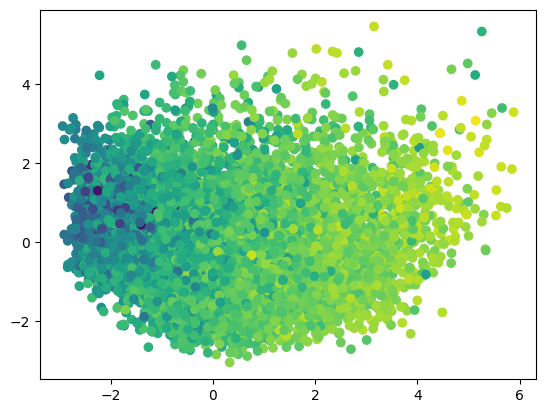

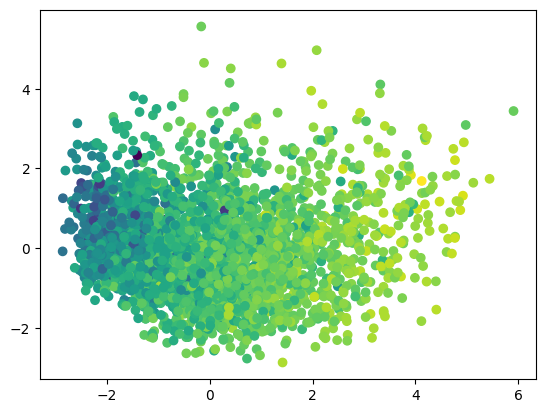

In [11]:
rf = RF(ratings,genome_scores, SEED)

In [12]:
rf.tuning()

c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'random_state': 1038893, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50}
Best score: 0.9465


In [13]:
rf.train()
rf.test()  

c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


MSE: 0.012127163985177493 RMSE: 0.11012340343985694 R2: 0.9494197987687645 MAE: 0.0845742608309641
Score:0.9494197987687645
